In [8]:
src_url = "https://storage.googleapis.com/wandb_datasets/nature_12K.zip"
src_zip = "nature_12K.zip"
DATA_TRAIN_SRC = "inaturalist_12K/train" 
DATA_TEST_SRC = "inaturalist_12K/val"
TRAIN_IMAGES_PER_LABEL = 1000
TEST_IMAGES_PER_LABEL = 200
BALANCED_SPLITS = {"train" : 900, "val" : 100}

In [10]:
%%capture
!curl -SL $src_url > $src_zip
!unzip $src_zip

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

!pip3 install tensorflow -qqq
!pip3 install wandb -qqq
import wandb
!wandb login
from wandb.keras import WandbCallback

     |████████████████████████████████| 2.1MB 18.9MB/s 
     |████████████████████████████████| 163kB 57.7MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 133kB 59.2MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
PROJECT_NAME = "CS6910 ASSIGNMENT 2"

**Upload Raw Train Data**

In [11]:
# source directory for all raw train data
SRC_TRAIN = DATA_TRAIN_SRC
# number of images per class label
# the total number of images is 10X this (10 classes)
TOTAL_IMAGES = TRAIN_IMAGES_PER_LABEL * 10
PREFIX_1 = "train" # convenient for tracking local data

TRAIN_RAW_DATA_AT = "_".join([PREFIX_1, "raw_data", str(TOTAL_IMAGES)])
run = wandb.init(project=PROJECT_NAME, job_type="upload")

# create an artifact for all the raw data
raw_data_at = wandb.Artifact(TRAIN_RAW_DATA_AT, type="raw_data")

# SRC_DIR contains 10 folders, one for each of 10 class labels
# each folder contains images of the corresponding class
labels = os.listdir(SRC_TRAIN)
for l in labels:
  imgs_per_label = os.path.join(SRC_TRAIN, l)
  if os.path.isdir(imgs_per_label):
    imgs = os.listdir(imgs_per_label)
    # randomize the order
    shuffle(imgs)
    img_file_ids = imgs[:TRAIN_IMAGES_PER_LABEL]
    for f in img_file_ids:
      file_path = os.path.join(SRC_TRAIN, l, f)
      # add file to artifact by full path
      raw_data_at.add_file(file_path, name=l + "/" + f)

# save artifact to W&B
run.log_artifact(raw_data_at)
run.finish()

**Upload Raw Test Data**

In [12]:
# source directory for all raw train data
SRC_TEST = DATA_TEST_SRC
# number of images per class label
# the total number of images is 10X this (10 classes)
TOTAL_IMAGES = TEST_IMAGES_PER_LABEL * 10
PREFIX_2 = "test" # convenient for tracking local data

TEST_RAW_DATA_AT = "_".join([PREFIX_2, "raw_data", str(TOTAL_IMAGES)])
run = wandb.init(project=PROJECT_NAME, job_type="upload")

# create an artifact for all the raw data
raw_data_at = wandb.Artifact(TEST_RAW_DATA_AT, type="raw_data")

# SRC_DIR contains 10 folders, one for each of 10 class labels
# each folder contains images of the corresponding class
labels = os.listdir(SRC_TEST)
for l in labels:
  imgs_per_label = os.path.join(SRC_TEST, l)
  if os.path.isdir(imgs_per_label):
    imgs = os.listdir(imgs_per_label)
    # randomize the order
    shuffle(imgs)
    img_file_ids = imgs[:TEST_IMAGES_PER_LABEL]
    for f in img_file_ids:
      file_path = os.path.join(SRC_TEST, l, f)
      # add file to artifact by full path
      raw_data_at.add_file(file_path, name=l + "/" + f)

# save artifact to W&B
run.log_artifact(raw_data_at)
run.finish()

**Split Train Data into Train and Validation**

In [13]:
run = wandb.init(project=PROJECT_NAME, job_type="data_split")

# find the most recent ("latest") version of the full raw data
# you can of course pass around programmatic aliases and not string literals
data_at = run.use_artifact(TRAIN_RAW_DATA_AT + ":latest")
# download it locally (for illustration purposes/across hardware; you can
# also sync/version artifacts by reference)
data_dir = data_at.download()

# create balanced train, val, test splits
# each count is the number of images per label
DATA_SPLITS = BALANCED_SPLITS

ats = {}
# wrap artifacts in dictionary for convenience
for split, count in DATA_SPLITS.items():
  ats[split] = wandb.Artifact("_".join([PREFIX_1, split, "data", str(count*10)]), 
                              "_".join([split, "data"]))

labels = os.listdir(data_dir)
for l in labels:
  if l.startswith("."): # skip non-label file
    continue
  imgs_per_label = os.listdir(os.path.join(data_dir, l))
  shuffle(imgs_per_label)
  start_id = 0
  for split, count in DATA_SPLITS.items():
    # take a subset
    split_imgs = imgs_per_label[start_id:start_id+count]
    for img_file in split_imgs:
      full_path = os.path.join(data_dir, l, img_file)
      # add file to artifact by full path
      # note: pass the label to the name parameter to retain it in
      # the data structure 
      ats[split].add_file(full_path, name = os.path.join(l, img_file))
    start_id += count

# save all three artifacts to W&B
# note: yes, in this example, we are cheating and have labels for the "val" data ;)
for split, artifact in ats.items():
  run.log_artifact(artifact)

run.finish()

wandb: Downloading large artifact train_raw_data_10000:latest, 3044.53MB. 10000 files... Done. 0:0:0


wandb: ERROR Control-C detected -- Run data was not synced


**Default Configuration**

In [14]:
MODEL_NAME = "CNN"
FINAL_MODEL_DIR = "trained_CNN"

config_defaults = {
    "img_size" : 229,
    "batch_size" : 100,
    "n_classes" : 10,
    "n_filters" : [16,32,64,64,128],
    "filter_size" : [3,3,3,3,3],
    "fc_size" : 400,
    "drop_out" : 0.5,
    "augmentation" : 1,
    "batch_normalize" : 1 
}

n_train = BALANCED_SPLITS["train"] * 10
n_val = BALANCED_SPLITS["val"] * 10
n_epochs = 14

**Define and Compile Model**

In [10]:
def cnn_model_1(img_size,n_filters,filter_size,fc_size,drop_out,n_classes):

   model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(n_filters[0], (filter_size[0],filter_size[0]), activation='relu', input_shape=(img_size,img_size,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(n_filters[1], (filter_size[1],filter_size[1]), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(n_filters[2], (filter_size[2],filter_size[2]), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(n_filters[3], (filter_size[3],filter_size[3]), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(n_filters[4], (filter_size[4],filter_size[4]), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Dropout(drop_out),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(fc_size, activation='relu'),
        tf.keras.layers.Dense(n_classes,activation="softmax")
    ])

   model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
   model.summary()
   return model

def cnn_model_2(img_size,n_filters,filter_size,fc_size,drop_out,n_classes):

   model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(n_filters[0], (filter_size[0],filter_size[0]), activation='relu', input_shape=(img_size,img_size,3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(n_filters[1], (filter_size[1],filter_size[1]), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(n_filters[2], (filter_size[2],filter_size[2]), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(n_filters[3], (filter_size[3],filter_size[3]), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(n_filters[4], (filter_size[4],filter_size[4]), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Dropout(drop_out),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(fc_size, activation='relu'),
        tf.keras.layers.Dense(n_classes,activation="softmax")
    ])

   model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
   model.summary()
   return model   

**Train Model**

In [15]:
def train():
  
  config_defaults = {
      "img_size" : 229,
      "batch_size" : 100,
      "n_classes" : 10,
      "n_filters" : [36,49,49,81,144],
      "filter_size" : [2,5,2,5,2],
      "fc_size" : 250,
      "drop_out" : 0.2,
      "augmentation" : 1,
      "batch_normalize" : 1 
  }

  # track this experiment with wandb: all runs will be sent to the given project name
  run = wandb.init(config=config_defaults,job_type='train')
  cfg = wandb.config

  # artifact names
  train_at = os.path.join(PROJECT_NAME, PREFIX_1 + "_train_data_" + str(n_train)) + ":latest"
  val_at = os.path.join(PROJECT_NAME, PREFIX_1 + "_val_data_" + str(n_val)) + ":latest"

  train_data = run.use_artifact(train_at, type='train_data')
  train_dir = train_data.download()
  val_data = run.use_artifact(val_at, type='val_data')
  val_dir = val_data.download()

  # create augmented train and validation data generators
  if cfg.augmentation == 1:
    train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=36,
      shear_range=0.3,
      zoom_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')
  else  :
    train_datagen = ImageDataGenerator(rescale = 1. /255)
  
  val_datagen = ImageDataGenerator(rescale = 1. / 255)

  train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(cfg.img_size, cfg.img_size),
    batch_size=cfg.batch_size,
    class_mode='categorical')

  val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(cfg.img_size, cfg.img_size),
    batch_size=cfg.batch_size,
    class_mode='categorical')
  
  # cfg.n_filters=[np.random.choice(cfg.n_filters_val) for i in range(5)]   #hidden layer sizes array creation

  # cfg.filter_size=[np.random.choice(cfg.filter_size_val) for i in range(5)]

  # instantiate model and callbacks
  if cfg.batch_normalize==1 :
    model = cnn_model_1(cfg.img_size,cfg.n_filters,cfg.filter_size,cfg.fc_size,cfg.drop_out,cfg.n_classes)

  elif cfg.batch_normalize==0 :
    model = cnn_model_2(cfg.img_size,cfg.n_filters,cfg.filter_size,cfg.fc_size,cfg.drop_out,cfg.n_classes) 
  
 
  # train and validate
  history = model.fit(
      train_generator,
      steps_per_epoch = n_train // cfg.batch_size,
      epochs = n_epochs,
      validation_data=val_generator,
      callbacks = [WandbCallback()],
      validation_steps = n_val // cfg.batch_size)

  # save trained model as artifact
  trained_model_artifact = wandb.Artifact(
            MODEL_NAME, type="model",
            description="trained cnn model",
            metadata=dict(cfg))

  model.save(FINAL_MODEL_DIR)
  trained_model_artifact.add_dir(FINAL_MODEL_DIR)
  run.log_artifact(trained_model_artifact)
  run.finish()

In [16]:
train()

wandb: Downloading large artifact train_train_data_9000:latest, 2741.26MB. 9000 files... Done. 0:0:0
wandb: Downloading large artifact train_val_data_1000:latest, 303.27MB. 1000 files... Done. 0:0:0


Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 228, 228, 36)      468       
_________________________________________________________________
batch_normalization (BatchNo (None, 228, 228, 36)      144       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 114, 114, 36)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 49)      44149     
_________________________________________________________________
batch_normalization_1 (Batch (None, 110, 110, 49)      196       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 49)        0         
____________________________________

wandb: Adding directory to artifact (./trained_CNN)... Done. 0.4s


epoch,13
loss,1.54709
accuracy,0.45327
val_loss,2.12643
val_accuracy,0.34
_runtime,2842
_timestamp,1618334672
_step,13
best_val_loss,1.79256
best_epoch,7


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▅▄▄▄▃▃▃▂▂▂▂▁▁
accuracy,▁▃▄▄▅▅▆▆▇▇▇▇██
val_loss,█▇██▃▃▂▁▂▃▂▄▃▃
val_accuracy,▁▁▂▂▄▅▇█▆▇▇▇▆▇
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


In [12]:
def sweeper(sweep_config,PROJECT_NAME):
  sweep_id=wandb.sweep(sweep_config,project=PROJECT_NAME)
  wandb.agent(sweep_id,train,project=PROJECT_NAME)

In [13]:
#sweep dictionary
sweep_config={
    'method':'bayes',
    'metric':{
        'name':'accuracy',
        'goal':'maximize'},

}

parameters_dict={
    
   # 'n_filters_val':{
   #     'values':[[32,64,128]]
   # },
    'n_filters':{
        'values':[[36,49,64,64,121],[36,49,49,81,144],[49,64,96,121,169],[64,64,81,128,225]]
    },
    'filter_size_val':{
        'values':[[2,3,5]]
    },
    'fc_size':{
        'values':[250,140,400]
    },
    'drop_out':{
        'values':[0,0.2,0.5,0.7,0.3]
    },
    'augmentation':{
      'values':[1,0]  
    },
    'batch_normalize':{
        'values':[1,0]
    },
    'batch_size':{
        'values':[180,100]
    },
}

sweep_config['parameters']=parameters_dict

In [ ]:
sweeper(sweep_config,PROJECT_NAME)

In [23]:
from tensorflow.keras.preprocessing import image

run = wandb.init(project=PROJECT_NAME, job_type="inference")
# use the latest version of the model
model_at = run.use_artifact('rohithd/uncategorized/CNN:v0', type='model')
# download the directory in which the model is saved
model_dir= model_at.download()
print("model: ", model_dir)
model = tf.keras.models.load_model(model_dir)

test_data_at = run.use_artifact(TEST_RAW_DATA_AT+ ":latest")
test_dir = test_data_at.download()

imgs = []
class_labels = os.listdir(test_dir)
for l in class_labels:
  if l.startswith("."):
    continue
  imgs_per_class = os.listdir(os.path.join(test_dir, l))
  for img in imgs_per_class:
    img_path = os.path.join(test_dir, l, img)
    img = image.load_img(img_path, target_size=(229, 229))
    img = image.img_to_array(img)
    # don't forget to rescale test images to match the range of inputs
    # to the network
    img = np.expand_dims(img/255.0, axis=0)
    imgs.append(img)

preds = {}
imgs = np.vstack(imgs)
classes = model.predict(imgs, batch_size=32)
for c in classes:
  class_id = np.argmax(c)
  if class_id in preds:
    preds[class_id] += 1
  else:
    preds[class_id] = 1

# print the counts of predicted labels as a quick sanity check
# note that for tiny/medium datasets, this won't be very meaningful
print(preds)
run.finish()

model:  ./artifacts/CNN:v0


wandb: Downloading large artifact test_raw_data_2000:latest, 604.34MB. 2000 files... Done. 0:0:0


{5: 259, 8: 506, 6: 395, 1: 142, 2: 170, 4: 244, 3: 124, 9: 49, 0: 74, 7: 37}


In [37]:
from keras.models import Model
modelConv1=Model(inputs=model.inputs, outputs=model.layers[0].output)

# take a random image "img"

ValueError: ignored

In [20]:
modelConv1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 229, 229, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 228, 228, 36)      468       
Total params: 468
Trainable params: 468
Non-trainable params: 0
_________________________________________________________________


In [62]:
preds=modelConv1.predict(imgs[4:8],batch_size=32)

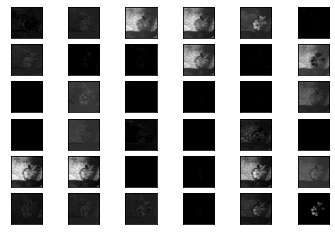

In [63]:
from matplotlib import pyplot

square = 6
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(preds[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [30]:
a=imgs[0]

In [43]:
for layer in modelConv1.layers:
    print(layer.output_shape)


[(None, 229, 229, 3)]
(None, 228, 228, 36)
